data preprocessing

In [1]:
#=============================================
#       step 1 - Load the dataset
#=============================================
import pandas as pd
import numpy as np

#=============================================
#       power consumption file
#=============================================

#the power consumption data is per minute data...so we are converting it to per hour to match the enviroinment data
power_file='household_power_consumption.csv'
df=pd.read_csv(power_file)
print("Before preocessing")
print(df.head())
print()

print("After Processing")
df_power=pd.read_csv(power_file,
                     sep=',',
                     parse_dates={'datetime': ['Date','Time']},
                     dayfirst=True,
                     low_memory=False,
                     na_values=['?']) #NaN='?'

#convert columns to numeric
cols_to_numeric=['Global_active_power','Global_reactive_power','Voltage','Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']
df_power[cols_to_numeric]=df_power[cols_to_numeric].apply(pd.to_numeric, errors='coerce')

#set datetime index 
df_power['datetime']=pd.to_datetime(df_power['datetime'], dayfirst=True)
df_power.set_index('datetime',inplace=True)

# Aggregate to hourly
df_hourly = df_power.resample('H').agg({
    'Global_active_power': 'mean',
    'Global_reactive_power': 'mean',
    'Voltage': 'mean',
    'Global_intensity': 'mean',
    'Sub_metering_1': 'sum',
    'Sub_metering_2': 'sum',
    'Sub_metering_3': 'sum'
})

# Target: total hourly energy in kWh
df_hourly['total_kWh'] = df_hourly['Global_active_power']  # Excellent approximation

# Optional: Fill small gaps if any (forward fill)
df_hourly = df_hourly.ffill().bfill()

print("First few hourly rows after aggregation:")
print(df_hourly.head())
print(f"\nData range: {df_hourly.index.min()} to {df_hourly.index.max()}")
print(f"Total hourly samples: {len(df_hourly)}")

C:\Users\91989\AppData\Local\Temp\ipykernel_19940\1746401703.py:13: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(power_file)


Before preocessing
         Date      Time Global_active_power Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00               4.216                 0.418  234.840   
1  16/12/2006  17:25:00               5.360                 0.436  233.630   
2  16/12/2006  17:26:00               5.374                 0.498  233.290   
3  16/12/2006  17:27:00               5.388                 0.502  233.740   
4  16/12/2006  17:28:00               3.666                 0.528  235.680   

  Global_intensity Sub_metering_1 Sub_metering_2  Sub_metering_3  
0           18.400          0.000          1.000            17.0  
1           23.000          0.000          1.000            16.0  
2           23.000          0.000          2.000            17.0  
3           23.000          0.000          1.000            17.0  
4           15.800          0.000          1.000            17.0  

After Processing


C:\Users\91989\AppData\Local\Temp\ipykernel_19940\1746401703.py:19: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df_power=pd.read_csv(power_file,
C:\Users\91989\AppData\Local\Temp\ipykernel_19940\1746401703.py:35: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df_power.resample('H').agg({


First few hourly rows after aggregation:
                     Global_active_power  Global_reactive_power     Voltage  \
datetime                                                                      
2006-12-16 17:00:00             4.222889               0.229000  234.643889   
2006-12-16 18:00:00             3.632200               0.080033  234.580167   
2006-12-16 19:00:00             3.400233               0.085233  233.232500   
2006-12-16 20:00:00             3.268567               0.075100  234.071500   
2006-12-16 21:00:00             3.056467               0.076667  237.158667   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
datetime                                                                
2006-12-16 17:00:00         18.100000             0.0            19.0   
2006-12-16 18:00:00         15.600000             0.0           403.0   
2006-12-16 19:00:00         14.503333             0.0            86.0   
2006-12-16 20:00:00         13.916667   

In [2]:
#===========================================
#       enviroinment data
#===========================================

weather_file="paris_weather_2006_2010.csv"
df=pd.read_csv(weather_file)
print("Before Processing")
print("Columns in your weather CSV:")
print(df.columns.tolist())
print(df.head())

print("After Processing")
df_weather=pd.read_csv(weather_file, parse_dates=['time'])
df_weather.set_index('time', inplace=True)
df_weather.index.name = 'datetime'

# Make sure it's hourly and sorted
df_weather = df_weather.sort_index()
print("first few datas in env data")
print(df_weather.head())
print(f"Weather data range: {df_weather.index.min()} to {df_weather.index.max()}")
print("Number of datas : ", len(df_weather))

Before Processing
Columns in your weather CSV:
['time', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'surface_pressure', 'precipitation', 'windspeed_10m', 'winddirection_10m']
               time  temperature_2m  relative_humidity_2m  dew_point_2m  \
0  2006-01-01T00:00             3.9                    92           2.7   
1  2006-01-01T01:00             3.9                    92           2.7   
2  2006-01-01T02:00             3.7                    92           2.5   
3  2006-01-01T03:00             3.2                    93           2.2   
4  2006-01-01T04:00             2.9                    94           2.0   

   surface_pressure  precipitation  windspeed_10m  winddirection_10m  
0             997.4            0.0           18.5                233  
1             997.5            0.0           18.8                234  
2             997.4            0.0           18.8                234  
3             997.3            0.0           18.9                230  
4    

In [3]:
#==================================================================
#   keep only the data present in both env and consumption data
#==================================================================
data = df_hourly.join(df_weather, how='inner')  # Keeps only hours present in both

print(data.columns.tolist())
print(data.head())
print(f"Merged data range: {data.index.min()} to {data.index.max()}")
print(f"Total hourly samples: {len(data)}")
print("Number of datas : ", len(df_weather))

['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'total_kWh', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'surface_pressure', 'precipitation', 'windspeed_10m', 'winddirection_10m']
                     Global_active_power  Global_reactive_power     Voltage  \
datetime                                                                      
2006-12-16 17:00:00             4.222889               0.229000  234.643889   
2006-12-16 18:00:00             3.632200               0.080033  234.580167   
2006-12-16 19:00:00             3.400233               0.085233  233.232500   
2006-12-16 20:00:00             3.268567               0.075100  234.071500   
2006-12-16 21:00:00             3.056467               0.076667  237.158667   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
datetime                                                                
2006-12-16 17:00:00 

In [4]:
#==================================================
#        cleaning and feature engineering
#==================================================

data=data.ffill().bfill() #fill the na rows

# Feature engineering
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek  # 0=Monday
data['month'] = data.index.month
data['season'] = (data['month'] % 12 + 3) // 3  # 1=Winter, 2=Spring, 3=Summer, 4=Autumn

# Lag features (previous hours' consumption)
for lag in range(1, 25):  # lag_1 to lag_24
    data[f'lag_{lag}'] = data['total_kWh'].shift(lag)

# Drop rows with NaN from lagging
data = data.dropna()

# Now save if you want
data.to_csv('merged_hourly_dataset.csv')

# Train/test split by time
train = data[:'2009-12-31']
test = data['2010-01-01':]

print(f"Train samples: {len(train)}, Test samples: {len(test)}")

Train samples: 26647, Test samples: 7918


EDA

(34565, 43)


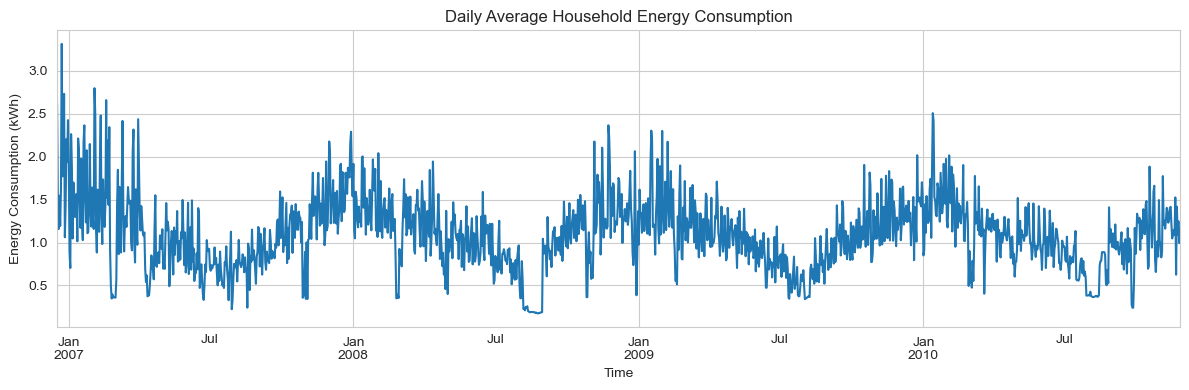

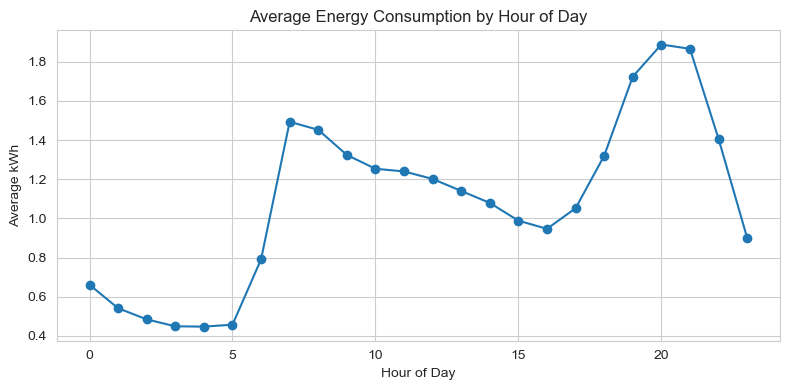

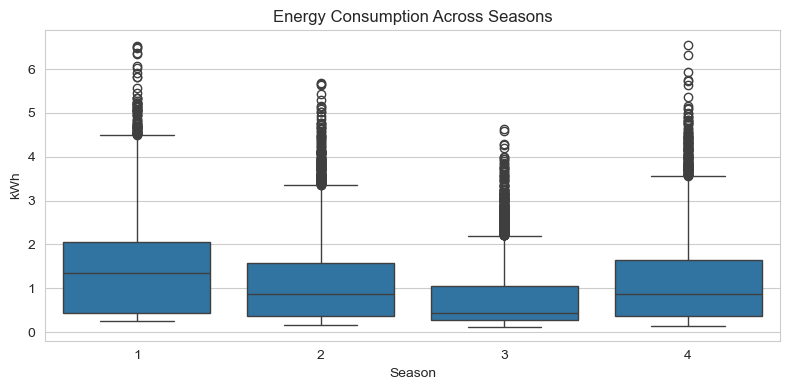

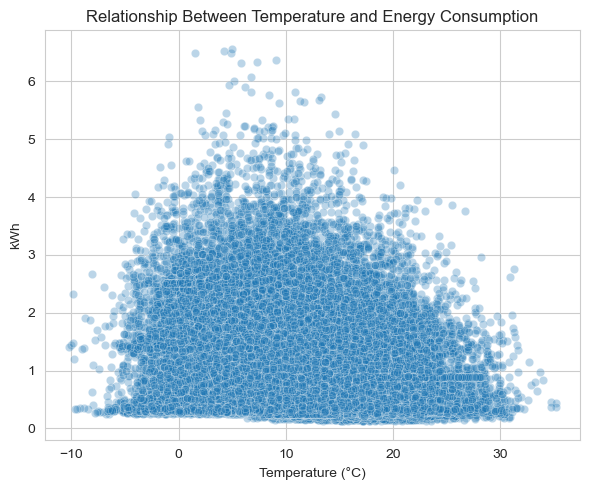

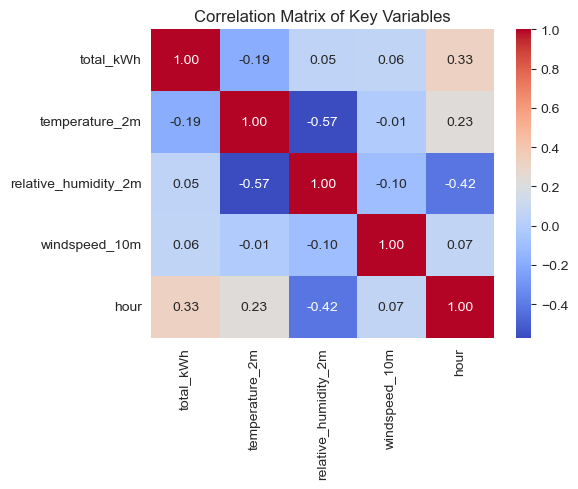

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

d = pd.read_csv(
    "merged_hourly_dataset.csv",
    parse_dates=["datetime"],
    index_col="datetime"
)

print(d.shape)
d.head()

# plot-1 consumption treend based on time series
# infers - Energy consumption exhibits clear seasonal and long-term variations, motivating time-aware forecasting models.

plt.figure(figsize=(12,4))
data['total_kWh'].resample('D').mean().plot()
plt.title("Daily Average Household Energy Consumption")
plt.xlabel("Time")
plt.ylabel("Energy Consumption (kWh)")
plt.tight_layout()
plt.show()

# plot-2 Hourly usage pattern - dinural cycle - justifies CNN
# infers - Strong diurnal patterns are observed, with higher consumption during morning and evening hours.
hourly_profile = data.groupby('hour')['total_kWh'].mean()

plt.figure(figsize=(8,4))
hourly_profile.plot(marker='o')
plt.title("Average Energy Consumption by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average kWh")
plt.tight_layout()
plt.show()

#plot-3 Seasonal consumption pattern
# infers - Seasonal variability indicates the influence of climatic conditions on household energy usage.

plt.figure(figsize=(8,4))
sns.boxplot(x='season', y='total_kWh', data=data)
plt.title("Energy Consumption Across Seasons")
plt.xlabel("Season")
plt.ylabel("kWh")
plt.tight_layout()
plt.show()

# plot-4 weather vs consumption (temperature)
# infers - Energy consumption shows a moderate dependency on ambient temperature, supporting the inclusion of environmental variables.

plt.figure(figsize=(6,5))
sns.scatterplot(
    x='temperature_2m',
    y='total_kWh',
    data=data,
    alpha=0.3
)
plt.title("Relationship Between Temperature and Energy Consumption")
plt.xlabel("Temperature (°C)")
plt.ylabel("kWh")
plt.tight_layout()
plt.show()

# plot-5 Correlation heatmap
# infers - Correlation analysis reveals that energy consumption is influenced by a combination of temporal and environmental factors.

corr_features = [
    'total_kWh',
    'temperature_2m',
    'relative_humidity_2m',
    'windspeed_10m',
    'hour'
]

plt.figure(figsize=(6,5))
sns.heatmap(
    data[corr_features].corr(),
    annot=True,
    cmap='coolwarm',
    fmt=".2f"
)
plt.title("Correlation Matrix of Key Variables")
plt.tight_layout()
plt.show()



Test Train Split

In [6]:
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

# Load data
data = pd.read_csv('merged_hourly_dataset.csv', parse_dates=['datetime'], index_col='datetime')

# Outlier removal (z-score < 3 across all numeric columns)
numeric_cols = data.select_dtypes(include=np.number).columns
data = data[(np.abs(stats.zscore(data[numeric_cols])) < 3).all(axis=1)]

# Train/test split - ADD .copy() HERE to avoid warnings
train = data[:'2009-12-31'].copy()
test = data['2010-01-01':].copy()


num_cols = [col for col in train.columns if col != 'total_kWh']

scaler = MinMaxScaler()

train[num_cols] = scaler.fit_transform(train[num_cols])
test[num_cols]  = scaler.transform(test[num_cols])

# Outlier removal ONLY on training data
numeric_cols = train.select_dtypes(include=np.number).columns
z_scores = np.abs(stats.zscore(train[numeric_cols]))
train = train[(z_scores < 3).all(axis=1)]

# Scalers
# scaler_features = MinMaxScaler()
# scaler_target = MinMaxScaler()

# # Features to scale (everything except target)
# feature_cols = [col for col in data.columns if col != 'total_kWh']

# # Scale features
# train[feature_cols] = scaler_features.fit_transform(train[feature_cols])
# test[feature_cols] = scaler_features.transform(test[feature_cols])

# # Scale target separately
# train[['total_kWh']] = scaler_target.fit_transform(train[['total_kWh']])
# test[['total_kWh']] = scaler_target.transform(test[['total_kWh']])

print(f"Pre-processing complete!")
print(f"Train shape: {train.shape}, Test shape: {test.shape}")
print(f"Features scaled: {len(num_cols)}, Target scaled separately.")
# print(f"Features scaled: {len(feature_cols)}, Target scaled separately.")

Pre-processing complete!
Train shape: (13608, 43), Test shape: (6612, 43)
Features scaled: 42, Target scaled separately.


In [7]:
#prepare data for the 2 branches

#=================================================
#       Branch 1: Random Forest (Tabular features)
#=================================================

# These are the features RF will use — environmental + temporal + recent lags
rf_features = [
    'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
    'surface_pressure', 'precipitation', 'windspeed_10m', 'winddirection_10m',
    'hour', 'day_of_week', 'month', 'season',
    'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6'  # You can include up to lag_24 if you want
    # Note: lag_1 = previous hour, lag_2 = 2 hours ago, etc.
]


# rf_features = [
#     'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
#     'surface_pressure', 'precipitation', 'windspeed_10m', 'winddirection_10m',
#     'hour', 'day_of_week', 'month', 'season',
#     'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8',
#     'lag_9', 'lag_10', 'lag_11', 'lag_12'  # You can include up to lag_24 if you want
#     # Note: lag_1 = previous hour, lag_2 = 2 hours ago, etc.
# ]

train_rf = train.dropna(subset=rf_features + ['total_kWh']).copy()
test_rf  = test.dropna(subset=rf_features + ['total_kWh']).copy()

# Simple tabular inputs — no sequences
X_rf_train = train[rf_features].values          # shape: (n_train, n_features)
y_rf_train = train['total_kWh'].values          # shape: (n_train,)

X_rf_test = test[rf_features].values
y_rf_test = test['total_kWh'].values

print(f"RF Branch - Train shape: {X_rf_train.shape}, Test shape: {X_rf_test.shape}")


#=================================================
#       Branch 2: CNN (Sequence of past consumption)
#=================================================

def create_sequences(df, seq_length=24):
    """
    Creates sequences of past total_kWh for CNN input.
    Input: past 24 hours → Predict: next hour
    """
    xs = []
    ys = []
    values = df.values
    for i in range(len(values) - seq_length):
        xs.append(values[i:i + seq_length].reshape(-1, 1))  # (24, 1)
        ys.append(values[i + seq_length])                   # scalar
    return np.array(xs), np.array(ys)

# Create sequences
X_cnn_train, y_cnn_train = create_sequences(train['total_kWh'],seq_length=24)
X_cnn_test, y_cnn_test = create_sequences(test['total_kWh'],seq_length=24)

# Shapes: (samples, 24, 1)
print(f"CNN Branch - Train shape: {X_cnn_train.shape}, Test shape: {X_cnn_test.shape}")
print(f"                    y shape: {y_cnn_train.shape}, {y_cnn_test.shape}")

RF Branch - Train shape: (13608, 17), Test shape: (6612, 17)
CNN Branch - Train shape: (13584, 24, 1), Test shape: (6588, 24, 1)
                    y shape: (13584,), (6588,)


Model Training

Branch 1 Random forest

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_rf_train, y_rf_train)

# Predictions
y_rf_train_pred = rf.predict(X_rf_train)
y_rf_test_pred  = rf.predict(X_rf_test)

# Metrics
def regression_metrics(y_true, y_pred, name=""):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f"{name} RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")

print("Random Forest Performance:")
regression_metrics(y_rf_train, y_rf_train_pred, "Train")
regression_metrics(y_rf_test,  y_rf_test_pred,  "Test")


Random Forest Performance:
Train RMSE: 0.2982 | MAE: 0.2038 | R²: 0.7548
Test RMSE: 0.4178 | MAE: 0.3002 | R²: 0.6126


initial:

Random Forest Performance:
Train RMSE: 0.2319 | MAE: 0.1556 | R²: 0.8517
Test RMSE: 0.4164 | MAE: 0.2953 | R²: 0.6151

reducing lag and change rf:

Random Forest Performance:
Train RMSE: 0.3026 | MAE: 0.2066 | R²: 0.7474
Test RMSE: 0.4196 | MAE: 0.3011 | R²: 0.6093

change rf only keeping previous data as it :

Random Forest Performance:
Train RMSE: 0.2864 | MAE: 0.1938 | R²: 0.7737
Test RMSE: 0.4167 | MAE: 0.2947 | R²: 0.6147

d:\miniconda\envs\ml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


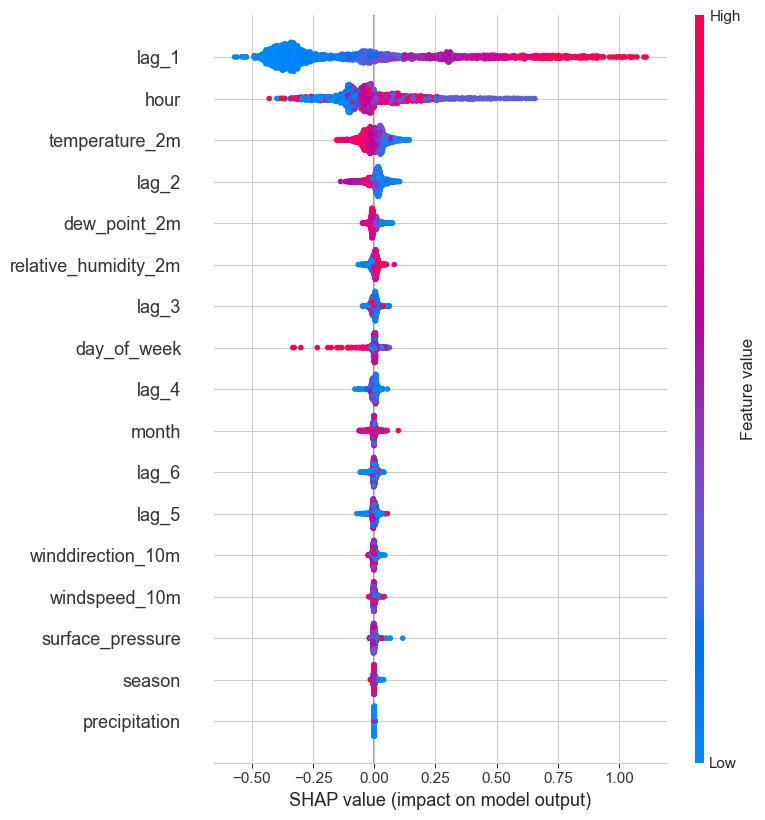

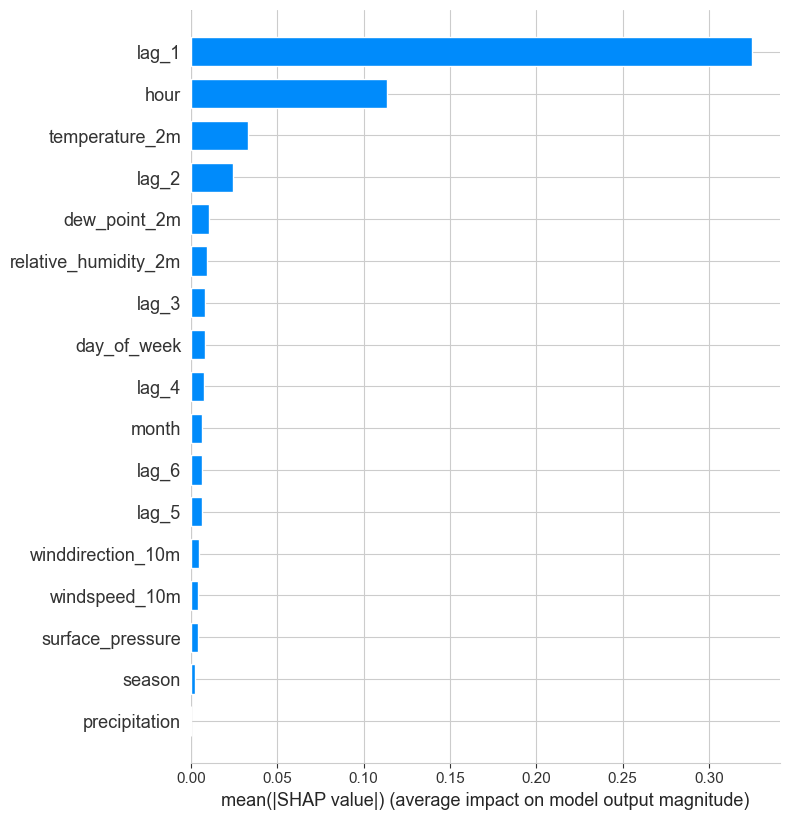

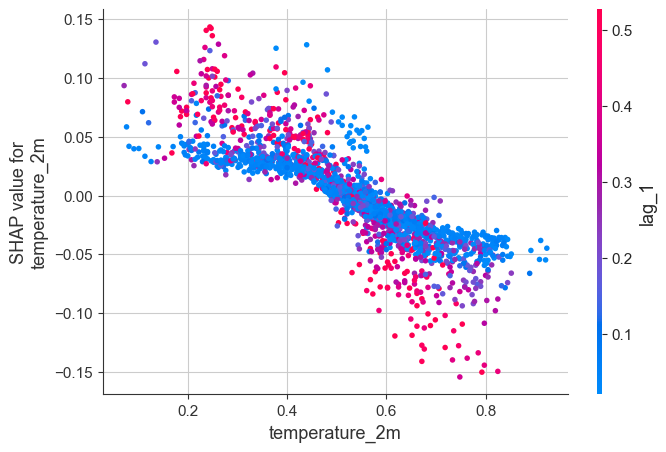

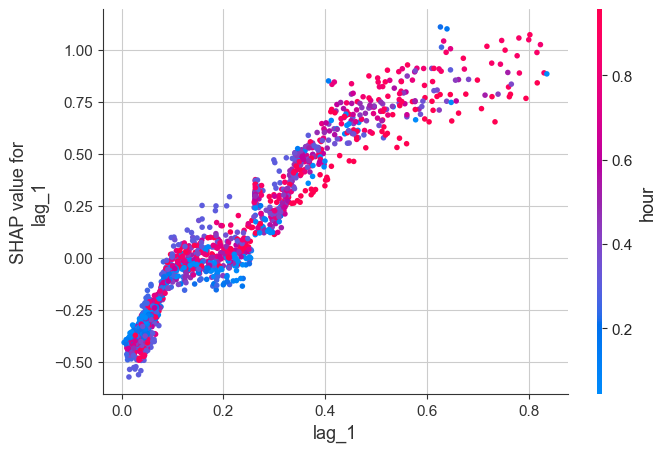

In [9]:
#explainability using shap for branch 1

import shap

#use tree eplainer

# Use a subset for speed
X_shap = X_rf_train[:2000]

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_shap)

#global features importance plot
shap.summary_plot(
    shap_values,
    X_shap,
    feature_names=rf_features
)


#bar plot
shap.summary_plot(
    shap_values,
    X_shap,
    feature_names=rf_features,
    plot_type="bar"
)

#single feature dependence
shap.dependence_plot(
    "temperature_2m",
    shap_values,
    X_shap,
    feature_names=rf_features
)

shap.dependence_plot(
    "lag_1",
    shap_values,
    X_shap,
    feature_names=rf_features
)

# For a single instance (e.g., row 0)
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[0],
    X_shap[0],
    feature_names=rf_features
)
# shap.force_plot(explainer.expected_value, shap_values[0], X_shap.iloc[0].values, feature_names=rf_features)


Branch 2 CNN

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

cnn = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(24, 1)),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # regression output
])

cnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

cnn.summary()



d:\miniconda\envs\ml\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 22, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 20, 32)         │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,841 (93.13 KB)

 Trainable params: 23,841 (93.13 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
#train the cnn

history = cnn.fit(
    X_cnn_train, y_cnn_train,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    verbose=1
)


#evaluate cnn based on results

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predictions
y_cnn_train_pred = cnn.predict(X_cnn_train).flatten()
y_cnn_test_pred  = cnn.predict(X_cnn_test).flatten()

def regression_metrics(y_true, y_pred, name=""):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f"{name} RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")

print("CNN Performance:")
regression_metrics(y_cnn_train, y_cnn_train_pred, "Train")
regression_metrics(y_cnn_test,  y_cnn_test_pred,  "Test")


Epoch 1/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.2976 - mae: 0.4103 - val_loss: 0.2079 - val_mae: 0.3433
Epoch 2/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2377 - mae: 0.3562 - val_loss: 0.2008 - val_mae: 0.3096
Epoch 3/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2281 - mae: 0.3436 - val_loss: 0.1965 - val_mae: 0.3234
Epoch 4/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2278 - mae: 0.3428 - val_loss: 0.1929 - val_mae: 0.3175
Epoch 5/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2265 - mae: 0.3416 - val_loss: 0.1948 - val_mae: 0.3265
Epoch 6/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2225 - mae: 0.3357 - val_loss: 0.1908 - val_mae: 0.3080
Epoch 7/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2221 - mae: 0.3370 - val_loss: 0.1934 - val_mae: 0.3080
Epoch 8/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2190 - mae: 0.3326 - val_loss: 0.1893 - val_mae: 0.3074
Epoch 9/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - l

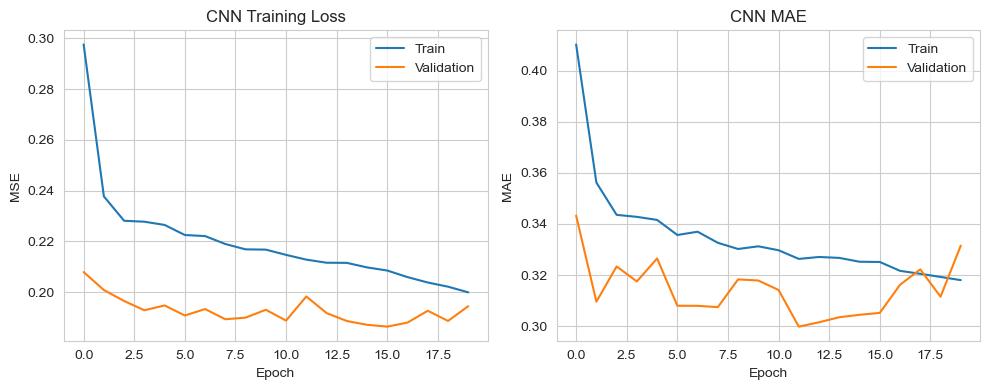

In [12]:
#plot training curves

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("CNN Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train')
plt.plot(history.history['val_mae'], label='Validation')
plt.title("CNN MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()

plt.tight_layout()
plt.show()


training again with data spliting again(this is our needed output)

In [13]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split  # For explicit split if needed

# Extract target for univariate sequences
df_merged=pd.read_csv("merged_hourly_dataset.csv")
kwh_series = df_merged['total_kWh'].values.reshape(-1, 1)  # Shape: (num_hours, 1)

# Normalize kWh only (for Branch 2)
scaler_kwh = MinMaxScaler()
kwh_scaled = scaler_kwh.fit_transform(kwh_series)

# Function to create univariate sequences (past 24 hours kWh -> next hour kWh)
def create_univariate_sequences(data, seq_len=24):
    X, y = [], []
    for i in range(len(data) - seq_len):
        seq = data[i:i+seq_len]  # Shape: (24, 1)
        X.append(seq)
        y.append(data[i+seq_len][0])  # Scalar next kWh (scaled)
    return np.array(X), np.array(y)

X_cnn, y_cnn = create_univariate_sequences(kwh_scaled)

# Time-based split: Train on 2006-2009, Test on 2010
# Calculate split index (approx 80% based on date range)
total_samples = len(df_merged)
train_size = int(total_samples * 0.8)  # Roughly up to end of 2009
X_cnn_train, X_cnn_test = X_cnn[:train_size], X_cnn[train_size:]
y_cnn_train, y_cnn_test = y_cnn[:train_size], y_cnn[train_size:]

print(f"X_cnn_train shape: {X_cnn_train.shape}")  # Should be (train_samples, 24, 1)
print(f"y_cnn_train shape: {y_cnn_train.shape}")  # (train_samples,)
print(f"X_cnn_test shape: {X_cnn_test.shape}")  # Should be (train_samples, 24, 1)
print(f"y_cnn_test shape: {y_cnn_test.shape}")

X_cnn_train shape: (27652, 24, 1)
y_cnn_train shape: (27652,)
X_cnn_test shape: (6889, 24, 1)
y_cnn_test shape: (6889,)


In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Train 
history = cnn.fit(
    X_cnn_train, y_cnn_train,
    validation_split=0.2,
    epochs=20,
    batch_size=64
)

# Predict (scaled)
y_cnn_train_pred_scaled = cnn.predict(X_cnn_train).flatten()
y_cnn_test_pred_scaled = cnn.predict(X_cnn_test).flatten()

# Inverse scale for evaluation
y_cnn_train_pred = scaler_kwh.inverse_transform(y_cnn_train_pred_scaled.reshape(-1, 1)).flatten()
y_cnn_test_pred = scaler_kwh.inverse_transform(y_cnn_test_pred_scaled.reshape(-1, 1)).flatten()
y_cnn_train_orig = scaler_kwh.inverse_transform(y_cnn_train.reshape(-1, 1)).flatten()
y_cnn_test_orig = scaler_kwh.inverse_transform(y_cnn_test.reshape(-1, 1)).flatten()

# Evaluation function (same as yours)
def regression_metrics(y_true, y_pred, name=""):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")

print("Refined CNN (Branch 2) Performance:")
regression_metrics(y_cnn_train_orig, y_cnn_train_pred, "Train")
regression_metrics(y_cnn_test_orig, y_cnn_test_pred, "Test")

Epoch 1/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0119 - mae: 0.0803 - val_loss: 0.0082 - val_mae: 0.0688
Epoch 2/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0103 - mae: 0.0741 - val_loss: 0.0079 - val_mae: 0.0668
Epoch 3/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0101 - mae: 0.0727 - val_loss: 0.0076 - val_mae: 0.0604
Epoch 4/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0098 - mae: 0.0715 - val_loss: 0.0074 - val_mae: 0.0620
Epoch 5/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0097 - mae: 0.0709 - val_loss: 0.0075 - val_mae: 0.0625
Epoch 6/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0095 - mae: 0.0696 - val_loss: 0.0076 - val_mae: 0.0600
Epoch 7/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0094 - mae: 0.0692 - val_loss: 0.0074 - val_mae: 0.0596
Epoch 8/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0093 - mae: 0.0683 - val_loss: 0.0074 - val_mae: 0.0626
Epoch 9/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - lo

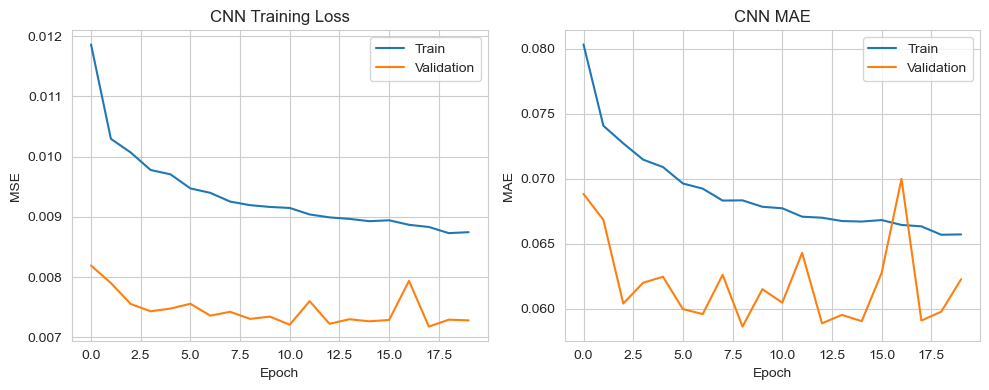

In [15]:
#plot training curves

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("CNN Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train')
plt.plot(history.history['val_mae'], label='Validation')
plt.title("CNN MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()

plt.tight_layout()
plt.show()


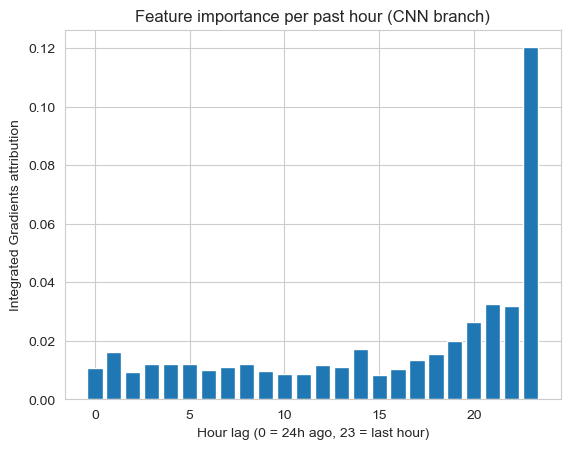

In [16]:
#explainability using integrated gradients

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Select a subset of test samples for explainability
X_explain = X_cnn_test[:200]  # shape: (200, 24, 1)
X_explain_tensor = tf.convert_to_tensor(X_explain, dtype=tf.float32)

# Define baseline (reference input)
# Option 1: zeros
baseline = tf.zeros_like(X_explain_tensor)
# Option 2 (optional): use mean of training sequences
# baseline = tf.convert_to_tensor(np.mean(X_cnn_train, axis=0, keepdims=True), dtype=tf.float32)

# Function to compute Integrated Gradients
def integrated_gradients(model, x, baseline, m_steps=50):
    """
    model: trained keras model
    x: input tensor of shape (batch_size, seq_len, 1)
    baseline: baseline tensor, same shape as x
    m_steps: number of interpolation steps
    """
    # Linear interpolation between baseline and input
    alphas = tf.linspace(0.0, 1.0, m_steps)
    interpolated_inputs = [baseline + alpha * (x - baseline) for alpha in alphas]
    interpolated_inputs = tf.stack(interpolated_inputs, axis=1)  # shape: (batch, m_steps, seq_len, 1)

    # Flatten batch for gradient computation
    batch_size, n_steps, seq_len, n_feat = interpolated_inputs.shape
    interpolated_flat = tf.reshape(interpolated_inputs, (-1, seq_len, n_feat))

    with tf.GradientTape() as tape:
        tape.watch(interpolated_flat)
        preds = model(interpolated_flat)
    
    grads = tape.gradient(preds, interpolated_flat)  # same shape as interpolated_flat
    grads = tf.reshape(grads, (batch_size, n_steps, seq_len, n_feat))

    # Average gradients across interpolation steps
    avg_grads = tf.reduce_mean(grads, axis=1)  # shape: (batch_size, seq_len, 1)
    
    # Compute Integrated Gradients
    ig = (x - baseline) * avg_grads
    return ig.numpy()

# Compute IG
ig_values = integrated_gradients(cnn, X_explain_tensor, baseline, m_steps=50)

# Average absolute IG across samples for global importance
mean_ig = np.abs(ig_values).mean(axis=0).flatten()  # shape: (24,)
# mean_ig_norm = mean_ig / mean_ig.sum()
# Plot hour-wise importance
# plt.figure(figsize=(10,5))
# plt.bar(range(24), mean_ig_norm)
# plt.xticks(range(24), list(range(0,24)))
# plt.gca().invert_xaxis()  # optional: show 24h ago on left
# plt.show()
plt.bar(range(24), mean_ig)
plt.xlabel("Hour lag (0 = 24h ago, 23 = last hour)")
plt.ylabel("Integrated Gradients attribution")
plt.title("Feature importance per past hour (CNN branch)")
plt.show()

#For the CNN branch, explainability is achieved using Integrated Gradients (IG), which attributes the model’s prediction to individual time steps in the 24-hour input sequence. IG computes the average gradients along a straight-line path between a baseline input and the actual input, producing a temporal importance score for each past hour. Global attribution is obtained by averaging absolute IG values across test samples. The results indicate that recent consumption hours have higher influence, reflecting the CNN’s ability to capture short-term temporal dependencies such as evening and morning usage peaks.

Knowledge distillation

In [22]:
# ======================================
#        RF teacher predictions
#=======================================

y_rf_train = rf.predict(X_rf_train)
y_rf_test  = rf.predict(X_rf_test)

# Ensure correct shape
y_rf_train = y_rf_train.reshape(-1, 1)
y_rf_test  = y_rf_test.reshape(-1, 1)

y_cnn_train = y_cnn_train.reshape(-1, 1)
y_cnn_test  = y_cnn_test.reshape(-1, 1)

X_cnn_train = X_cnn_train[-len(y_rf_train):]
y_cnn_train = y_cnn_train[-len(y_rf_train):]

print("X_cnn_train:", X_cnn_train.shape)
print("y_cnn_train:", y_cnn_train.shape)
print("y_rf_train :", y_rf_train.shape)

#=======================================
#             CNN Student
#=======================================

from tensorflow.keras import layers, models

def build_student_cnn():
    model = models.Sequential([
        layers.Conv1D(16, kernel_size=3, activation='relu', input_shape=(24, 1)),
        layers.MaxPooling1D(),
        layers.Flatten(),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    return model

student = build_student_cnn()

#=======================================
#           defining kd loss
#=======================================
mse = tf.keras.losses.MeanSquaredError()

alpha = 0.5  # weight for true labels (can tune later)

#======================================
#           kd training loop
#======================================
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

@tf.function
def train_step(x_batch, y_true_batch, y_rf_batch):
    with tf.GradientTape() as tape:
        y_pred = student(x_batch, training=True)

        loss_true = mse(y_true_batch, y_pred)
        loss_teacher = mse(y_rf_batch, y_pred)

        loss = alpha * loss_true + (1 - alpha) * loss_teacher

    grads = tape.gradient(loss, student.trainable_variables)
    optimizer.apply_gradients(zip(grads, student.trainable_variables))

    return loss, loss_true, loss_teacher

#============================================
#         training the cnn student
#============================================
EPOCHS = 20
BATCH_SIZE = 32

train_dataset = tf.data.Dataset.from_tensor_slices(
    (X_cnn_train, y_cnn_train, y_rf_train)
).shuffle(1000).batch(BATCH_SIZE)

for epoch in range(EPOCHS):
    total_loss = 0
    for x_batch, y_true_batch, y_rf_batch in train_dataset:
        loss, lt, lr = train_step(x_batch, y_true_batch, y_rf_batch)
        total_loss += loss.numpy()

    print(f"Epoch {epoch+1}/{EPOCHS} | KD Loss: {total_loss:.4f}")

#=============================================
#           evaluating the model
#=============================================
from sklearn.metrics import mean_squared_error, r2_score

y_student_pred = student.predict(X_cnn_test)

rmse = np.sqrt(mean_squared_error(y_cnn_test, y_student_pred))
r2 = r2_score(y_cnn_test, y_student_pred)

print("KD Student CNN RMSE:", rmse)
print("KD Student CNN R2:", r2)


X_cnn_train: (13608, 24, 1)
y_cnn_train: (13608, 1)
y_rf_train : (13608, 1)


d:\miniconda\envs\ml\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20 | KD Loss: 90.7279
Epoch 2/20 | KD Loss: 88.8082
Epoch 3/20 | KD Loss: 88.5758
Epoch 4/20 | KD Loss: 88.5574
Epoch 5/20 | KD Loss: 88.6264
Epoch 6/20 | KD Loss: 88.4656
Epoch 7/20 | KD Loss: 88.6203
Epoch 8/20 | KD Loss: 88.5649
Epoch 9/20 | KD Loss: 88.6182
Epoch 10/20 | KD Loss: 88.5499
Epoch 11/20 | KD Loss: 88.5490
Epoch 12/20 | KD Loss: 88.3144
Epoch 13/20 | KD Loss: 88.5812
Epoch 14/20 | KD Loss: 88.4742
Epoch 15/20 | KD Loss: 88.3607
Epoch 16/20 | KD Loss: 88.3440
Epoch 17/20 | KD Loss: 88.3104
Epoch 18/20 | KD Loss: 88.4291
Epoch 19/20 | KD Loss: 88.2912
Epoch 20/20 | KD Loss: 88.2491
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
KD Student CNN RMSE: 0.38045061011420117
KD Student CNN R2: -10.266655852352878
